In [54]:
import pandas as pd
import msgpack
from pathlib import Path

In [55]:
data_dir = Path("cv-results")

histories = [
    msgpack.loads(f.read_bytes())
    for f in data_dir.glob("*.msgpack")
]
history = sum(histories, [])

In [58]:
df = pd.DataFrame(history)
df.columns = [str(x).replace("b'", "").replace("'", "") for x in df.columns]
df["library"] = df.ident.apply(lambda x: str(x).split("-")[0].strip("b'"))
df.head()

,score,time,pf_calls,score_calls,ident,activation,alpha,batch_size,hidden_layer_sizes,max_iter,momentum,n_iter_no_change,prefix,random_state,solver,tol,library
0,0.2315,1.594873e+09,2,1,b'sklearn-03d776353dd648e34f94248a53183fb4f94c...,b'relu',0.000823,256,"[4, 4, 4, 4, 4, 4]",200,0.9,66,b'sklearn',3581,b'sgd',0.001,sklearn
1,0.2369,1.594873e+09,3,2,b'sklearn-03d776353dd648e34f94248a53183fb4f94c...,b'relu',0.000823,256,"[4, 4, 4, 4, 4, 4]",200,0.9,66,b'sklearn',3581,b'sgd',0.001,sklearn
2,0.2415,1.594873e+09,5,3,b'sklearn-03d776353dd648e34f94248a53183fb4f94c...,b'relu',0.000823,256,"[4, 4, 4, 4, 4, 4]",200,0.9,66,b'sklearn',3581,b'sgd',0.001,sklearn
3,0.2479,1.594873e+09,6,4,b'sklearn-03d776353dd648e34f94248a53183fb4f94c...,b'relu',0.000823,256,"[4, 4, 4, 4, 4, 4]",200,0.9,66,b'sklearn',3581,b'sgd',0.001,sklearn
4,0.2559,1.594873e+09,8,5,b'sklearn-03d776353dd648e34f94248a53183fb4f94c...,b'relu',0.000823,256,"[4, 4, 4, 4, 4, 4]",200,0.9,66,b'sklearn',3581,b'sgd',0.001,sklearn


In [68]:
print("Number of pf_calls:")
df.groupby("library")["pf_calls"].max()

Number of pf_calls:


library
dask        61
ray         99
sklearn    199
Name: pf_calls, dtype: int64

In [69]:
print("Number of models evaluaed:")
df.groupby("library")["ident"].nunique()

Number of models evaluaed:


library
dask        37
ray         29
sklearn    100
Name: ident, dtype: int64

In [70]:
import seaborn as sns

show = df.pivot_table(
    index="pf_calls",
    columns="library",
    values="score",
    aggfunc="max",
)
show.columns = [str(x).replace("b'", "").replace("'", "") for x in show.columns]
print("Number of null values:")
(~show.isnull()).sum()

Number of null values:


dask         7
ray         99
sklearn    199
dtype: int64

In [41]:
from typing import List, Dict, Any

def replay(hist: pd.DataFrame) -> List[Dict[str, Any]]:
    scores = {}
    data = []
    for _, row in hist.iterrows():
        scores[row["ident"]] = row["score"]
        datum = {"best_score": max(scores.values()), "cum_pf_calls": row["cum_pf_calls"]}
        data.append(datum)
    return data


dfs = []
for library in ["sklearn", "ray", "dask"]:
    show = df[df.library == library].copy()
    show = show.sort_values(by="time")
    assert (show.time.diff().iloc[1:] >= 0).all()
    show["cum_pf_calls"] = show["pf_calls"].cumsum()
    s = show[["ident", "score", "pf_calls", "cum_pf_calls"]]
    hist = replay(s)
    out = pd.DataFrame(hist)
    out["library"] = library
    dfs.append(out)

perf = pd.concat(dfs)
perf.head()

,best_score,cum_pf_calls,library
0,0.2900,1,sklearn
1,0.2900,2,sklearn
2,0.3228,3,sklearn
3,0.3228,4,sklearn
4,0.3228,5,sklearn


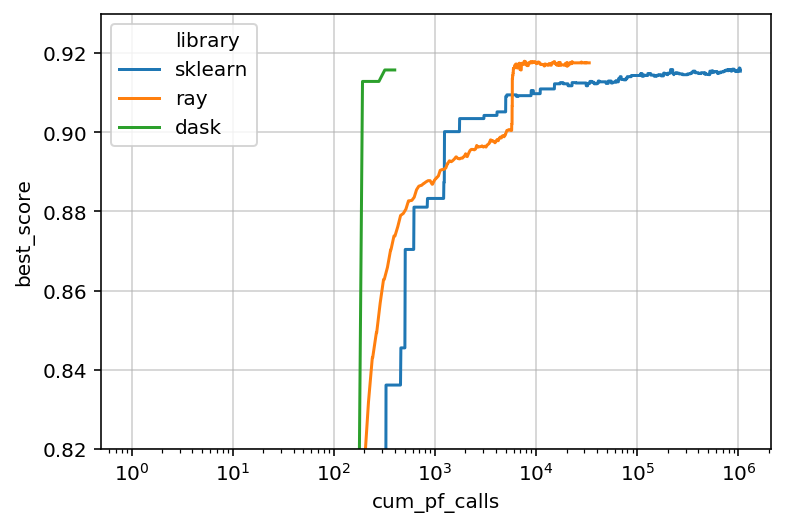

In [51]:
import seaborn as sns
ax = sns.lineplot(
    x="cum_pf_calls",
    y="best_score",
    hue="library",
    data=perf,
)
ax.set_ylim(0.82, 0.93)
ax.set_xscale("log")
ax.grid(alpha=0.6)

In [74]:
final = pd.read_csv("out/final.csv")
final.head()

,score,library,accuracy,best_score,best_params,fit_time,start_time
0,0.9122,ray,0.9122,0.9180,"{'hidden_layer_sizes': (12, 12), 'alpha': 0.00...",266.710466,1.594872e+09
1,0.9104,dask,0.9104,0.9182,"{'activation': 'relu', 'alpha': 7.502587716655...",98.391288,1.594872e+09
2,0.9106,sklearn,0.9106,0.9155,"{'activation': 'relu', 'alpha': 0.000160564066...",2815.054871,1.594873e+09


In [77]:
for row in final.best_params:
    print(row)

{'hidden_layer_sizes': (12, 12), 'alpha': 0.00031996949501205053, 'batch_size': 64, 'solver': 'adam', 'activation': 'relu', 'random_state': 4558}
{'activation': 'relu', 'alpha': 7.502587716655961e-05, 'batch_size': 64, 'hidden_layer_sizes': (12, 12), 'random_state': 6101, 'solver': 'adam'}
{'activation': 'relu', 'alpha': 0.00016056406613556388, 'batch_size': 64, 'hidden_layer_sizes': (12, 12), 'random_state': 262, 'solver': 'adam'}
